<a href="https://colab.research.google.com/github/DHYANAJPATEL/IBM_PROJECT/blob/main/IBM_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
np.random.seed(1337)
import pandas as pd

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import pathlib
import cv2
from tensorflow.keras import layers
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_testing = '/content/drive/MyDrive/Testing'

In [ ]:
path_training = '/content/drive/MyDrive/Training'

In [ ]:
path_testing = pathlib.Path(path_testing)
path_training = pathlib.Path(path_training)
print(path_training)

image_count = len(list(path_training.glob('*/*.jpg')))
print(image_count)
test_image_count = len(list(path_testing.glob('*/*.jpg')))
print(test_image_count)

/content/drive/MyDrive/Training
2870
394


/content/drive/MyDrive/Training/glioma_tumor/gg (10).jpg


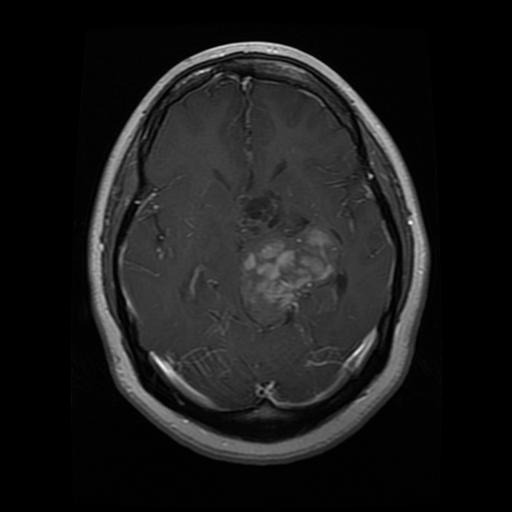

In [ ]:
tumor = list(path_training.glob('glioma_tumor/*'))
print(tumor[1])
imga = PIL.Image.open(str(tumor[0]))
imga

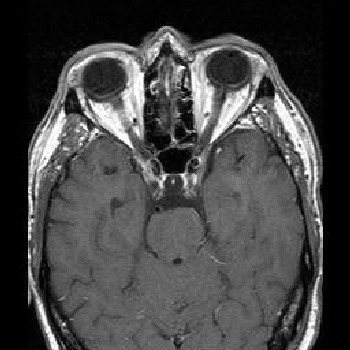

In [ ]:
notumor = list(path_training.glob('no_tumor/*'))
imgb = PIL.Image.open(str(notumor[0]))
imgb

In [ ]:
img_opencv = cv2.imread(str(notumor[0]))
print(img_opencv.shape)
img_opencv1 = cv2.imread(str(tumor[0]))
print(img_opencv1.shape)

(350, 350, 3)
(512, 512, 3)


In [ ]:
batch = 32
imageheight = 250
imagewidth = 250

In [ ]:
trainA = tf.keras.preprocessing.image_dataset_from_directory(
path_training,
validation_split = 0.2,
subset = 'training',
seed = 42,
image_size  =(imageheight,imagewidth),
batch_size = batch)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.


In [ ]:
valA = tf.keras.preprocessing.image_dataset_from_directory(
path_training,
validation_split = 0.2,
subset = 'validation',
seed = 42,
image_size = (imageheight,imagewidth),
batch_size = batch)

Found 2870 files belonging to 4 classes.
Using 574 files for validation.


In [ ]:
testA = tf.keras.preprocessing.image_dataset_from_directory(
path_testing,
seed = 42,
image_size = (imageheight,imagewidth),
batch_size = batch)

Found 394 files belonging to 4 classes.


In [ ]:
print(trainA.class_names)
print(valA.class_names)
print(testA.class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


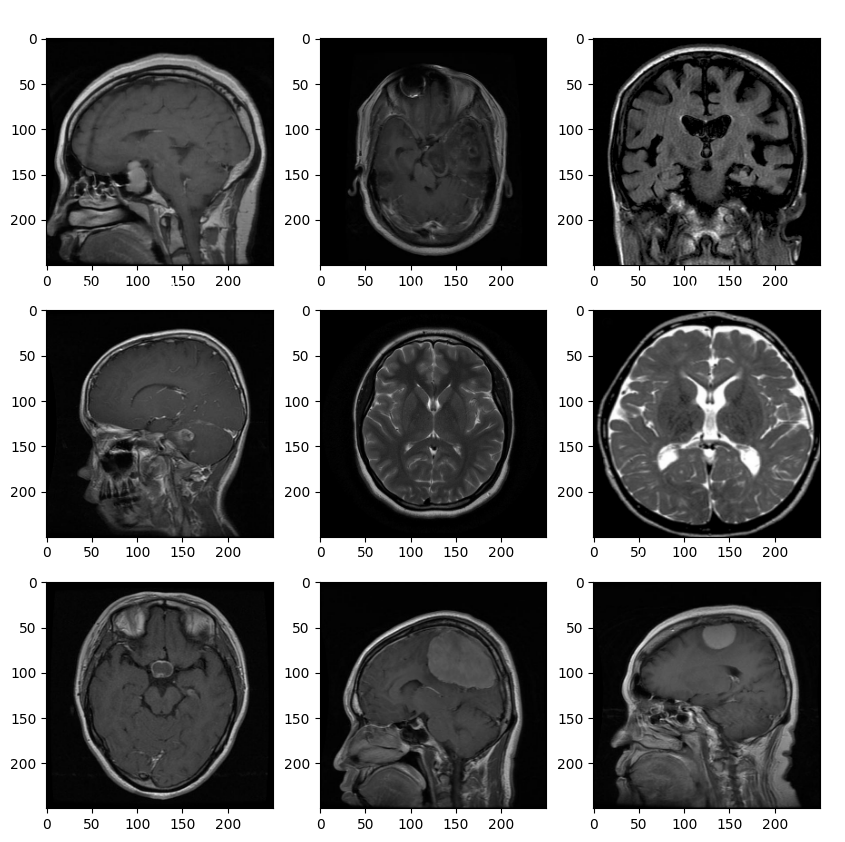

In [ ]:
classes = trainA.class_names
plt.figure(figsize = (10,10))
for img,label in trainA.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(classes[label[i]],
                  fontdict = {'fontsize': '19',
                              'color': 'white'}
                 )

In [ ]:
for image_batch, labels_batch in trainA:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 250, 250, 3)
(32,)


In [ ]:
AUTOTUNES = tf.data.AUTOTUNE

train = trainA.prefetch(buffer_size=AUTOTUNES)
val = valA.prefetch(buffer_size=AUTOTUNES)
test = testA.prefetch(buffer_size=AUTOTUNES)

In [ ]:
help(test.as_numpy_iterator())

Help on NumpyIterator in module tensorflow.python.data.ops.dataset_ops object:

class NumpyIterator(tensorflow.python.trackable.base.Trackable)
 |  NumpyIterator(dataset)
 |  
 |  Iterator over a dataset with elements converted to numpy.
 |  
 |  Method resolution order:
 |      NumpyIterator
 |      tensorflow.python.trackable.base.Trackable
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, dataset)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |  
 |  __next__(self)
 |  
 |  next(self)
 |  
 |  restore(self, state)
 |  
 |  save(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from tensorflow.python.trackable.base.Trackable:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [ ]:
def prediction_label_comparison(model,test):
    #Retrieving a batch of images from the test set
    image_batch, label_batch = test.as_numpy_iterator().next()
    prediction = model.predict_on_batch(image_batch).flatten()


    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4])
        n+=4
        predict.append(pred)
    predict = np.array(predict)


    print('Label:\n', label_batch)
    print('Prediction:\n',predict)
    '''
    print(predictions.shape)
    print(label_batch.shape)
    print(predict.shape)
    '''

    plt.figure(figsize=(10, 10))
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[i].astype("uint8"))
      plt.title(classes[predict[i]],fontdict = {'fontsize': '14',
                                  'color': 'white'})
      plt.axis("off")
    return label_batch , predict

In [ ]:
def test_tumor(list_testing_path,model):

    for path_name in list_testing_path:
        test_img_path = path_name


        test_image = tf.keras.preprocessing.image.load_img(
            test_img_path, target_size=(imageheight, imagewidth)
        )
        test_array = tf.keras.preprocessing.image.img_to_array(test_image)
        test_array = tf.expand_dims(test_array, 0) # Create a batch

        predictions = model.predict(test_array)
        score = tf.nn.softmax(predictions[0])

        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(classes[np.argmax(score)], 100 * np.max(score))
        )

In [ ]:
def csv_builder(path_training,label_names):
    dframe = pd.DataFrame(columns = ['images','labels'])
    for name in label_names:
        BASE_DIR = str(path_training)+'/'

        train_folder_name = BASE_DIR+name+'/'



        files_in_train = sorted(os.listdir(train_folder_name))


        image_names =[i for i in files_in_train]


        for x in image_names:
            dframe = df.append({'images':train_folder_name+str(x),'labels':name},ignore_index=True)



    return dframe

In [ ]:
def model_inputs(model2,train,val,test):
    num_classes = 4
    epochs = 15
    model2.fit(
        train,
        validation_data=val,
        epochs=epochs,
        #callbacks = callback,
        shuffle=False,
        verbose = 0
    )
    results = model2.evaluate(test)
    return results[0],results[1] , model

In [ ]:
def cross_validation(n_splits,final_csv,test_csv,img_width,img_height,model):
    final_loss = 0
    final_acc = 0

    '''
    Seperating a dataframe for testing data
    '''
    ##
    final_csv = final_csv.sample(frac=1)
    ##
    Y = final_csv[['labels']]
    n = len(Y)
    kf = KFold(n_splits = 5)
    #skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
    idg = ImageDataGenerator(#width_shift_range=0.1,
#                          height_shift_range=0.1,
#                          zoom_range=0.3,
#                          fill_mode='nearest',
#                          horizontal_flip = True,
                         rescale=1./255)




    print('Performing cross validation...')
    test = idg.flow_from_dataframe(test_csv,
                                       x_col = "images",
                                       y_col = "labels",
                                       class_mode = "sparse",
                                       shuffle = True,
                                      target_size = (img_width,img_height),
                                      verbose = 0)#,subset='validation')
#     test = tf.keras.preprocessing.image_dataset_from_directory(path_test,
#                                                                    seed = 42,
#                                                                    image_size = (img_height,img_width),
#                                                                    batch_size = 32)

    for train_index, val_index in kf.split(np.zeros(n),Y):
        training_data = final_csv.iloc[train_index]
        validation_data = final_csv.iloc[val_index]
        train = idg.flow_from_dataframe(training_data,
                                        x_col = "images",
                                        y_col = "labels",
                                        class_mode = "sparse",
                                        shuffle = True,
                                        subset='training',
                                       target_size = (img_width,img_height),
                                       verbose = 0)
        val = idg.flow_from_dataframe(validation_data,
                                      x_col = "images",
                                      y_col = "labels",
                                      class_mode = "sparse",
                                      shuffle = True,
                                     target_size = (img_width,img_height),
                                     verbose = 0)





        '''
        Passing of  the preprocessed data for model training
        '''
        loss,acc,returned_model = model_inputs(model,train,val,test)
        final_loss += loss
        final_acc += acc
    return final_loss/n_splits , final_acc/n_splits , returned_model


In [ ]:
normalizationoflayer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
convlayer32 = tf.keras.layers.Conv2D(32,(3,3),activation='relu')
convlayer64 = tf.keras.layers.Conv2D(64,3,activation='relu')
convlayer16 = tf.keras.layers.Conv2D(16,3,activation='relu')
maxpool = tf.keras.layers.MaxPooling2D()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    normalizationoflayer,
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),

    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),

  ]
)

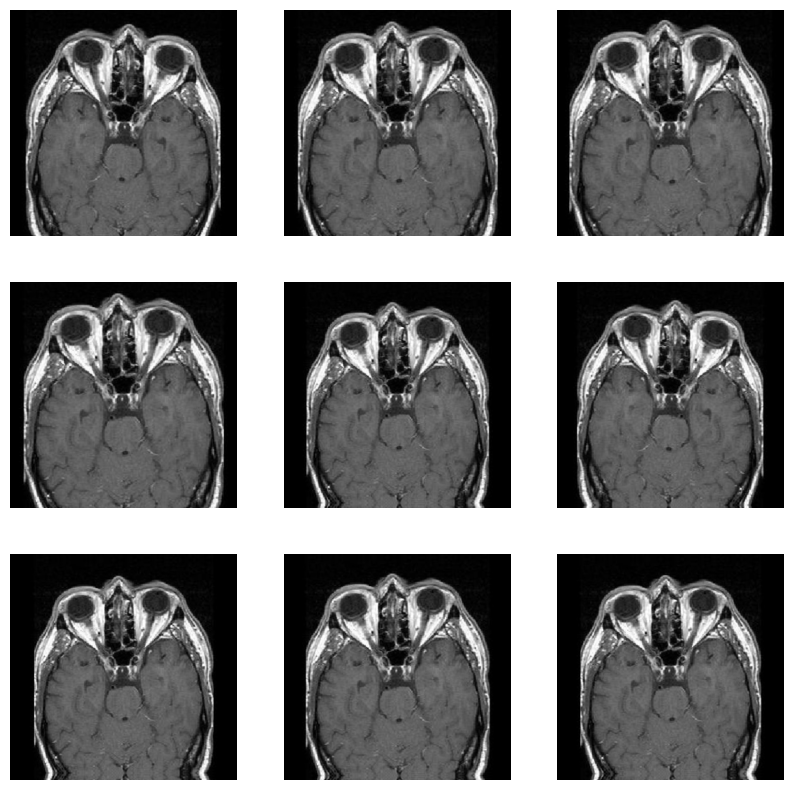

In [ ]:
plt.figure(figsize=(10, 10))
img_array = tf.keras.preprocessing.image.img_to_array(img_opencv)
img_array = tf.expand_dims(img_array,0)
for i in range(9):
  augmented_image = data_augmentation(img_array)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [ ]:
#Model Building
num_classes = 4

model = tf.keras.Sequential([
  normalizationoflayer,
  convlayer32,
  maxpool,
  convlayer32,
  maxpool,
  convlayer32,
  maxpool,
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history = model.fit(
    train,
    validation_data=val,
    epochs= 7,
    callbacks = callback,
    shuffle=False
)
eff_epochs = len(history.history['loss'])

Epoch 1/7
72/72 [==============================] - 472s 7s/step - loss: 1.9608 - accuracy: 0.5997 - val_loss: 0.5086 - val_accuracy: 0.7997
Epoch 2/7
72/72 [==============================] - 204s 3s/step - loss: 0.2315 - accuracy: 0.9155 - val_loss: 0.3496 - val_accuracy: 0.8693
Epoch 3/7
72/72 [==============================] - 185s 3s/step - loss: 0.0721 - accuracy: 0.9826 - val_loss: 0.3900 - val_accuracy: 0.8885
Epoch 4/7
72/72 [==============================] - 187s 3s/step - loss: 0.0240 - accuracy: 0.9965 - val_loss: 0.3887 - val_accuracy: 0.8885
Epoch 5/7
72/72 [==============================] - 196s 3s/step - loss: 0.0091 - accuracy: 0.9991 - val_loss: 0.3957 - val_accuracy: 0.8763
Epoch 6/7
72/72 [==============================] - 196s 3s/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.3820 - val_accuracy: 0.8920
Epoch 7/7
72/72 [==============================] - 197s 3s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.4025 - val_accuracy: 0.8937


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 492032)            0         
                                                                 
 dense (Dense)               (None, 128)               62980224  
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                      

In [ ]:
list_of_paths = ['/content/drive/MyDrive/Testing/pituitary_tumor/image(11).jpg',
                '/content/drive/MyDrive/Testing/no_tumor/image(104).jpg',
                '/content/drive/MyDrive/Testing/meningioma_tumor/image(100).jpg',
                '/content/drive/MyDrive/Testing/no_tumor/image(12).jpg',
                '/content/drive/MyDrive/Testing/pituitary_tumor/image(19).jpg']
test_tumor(list_of_paths,model)

1/1 [==============================] - 0s 51ms/step
This image most likely belongs to pituitary_tumor with a 100.00 percent confidence.
1/1 [==============================] - 0s 50ms/step
This image most likely belongs to no_tumor with a 100.00 percent confidence.
1/1 [==============================] - 0s 57ms/step
This image most likely belongs to meningioma_tumor with a 99.60 percent confidence.
1/1 [==============================] - 0s 57ms/step
This image most likely belongs to no_tumor with a 99.98 percent confidence.
1/1 [==============================] - 0s 54ms/step
This image most likely belongs to pituitary_tumor with a 99.95 percent confidence.
